# COMP4030 - Data Science and Machine Learning - Coursework 2

## Data collection and pre-processing
At this stage you can toggle which gestures you want to include in the training and testing by adding or removing elements from this functions return array.

In [41]:
def get_gestures():
      return ['circle', 'go', 'come', 'wave'] # 

In [42]:
# Utility functions - Ashley Hunt - psyah10
import os

def num_gestures():
      return len(get_gestures())

def get_columns():
    return ['time', 'accel_x', 'accel_y', 'accel_z', 'accel_abs']

def get_gesture_csvs(gesture_dir):
      if not os.path.exists(gesture_dir):
            os.makedirs(gesture_dir)
      return [file for file in os.listdir(gesture_dir) if file.endswith('.csv')]

### Data Importing
Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. 

In [43]:
# Data importing functions - Ashley Hunt - psyah10
import pandas as pd

## Simple function to read a csv file and return a dataframe
def get_df(path, trim=True):
      if not path.endswith('.csv'):
            return []
      
      raw_data = pd.read_csv(path)
      raw_data.columns = get_columns()

      df = pd.DataFrame(raw_data, columns=raw_data.columns)

      return trim_recording(df) if trim else df

## Function to trim the recording to the first and last significant movement
def trim_recording(df, window_size = 20, threshold = 0.3, padding=90):

      df['rolling_max'] = df['accel_abs'].rolling(window=window_size, min_periods=1).mean()

      start_cut = df[df['rolling_max'] >= threshold].index.min()
      if pd.notna(start_cut):
            cut_index = max(start_cut - padding, 0)
            df = df.loc[cut_index:]
      
      end_cut = df[df['rolling_max'] >= threshold].index.max()
      if pd.notna(end_cut):
            end_cut_index = min(end_cut + padding, len(df) - 1) 
            df = df.loc[:end_cut_index]

      df = df.drop('rolling_max', axis=1)
      return df

## Function to get all the data from the files in the data folder
def get_data_from_files(trim=True, test=False):
      sub_folder = 'test' if test else 'train'
      
      dfs = []
      gestures = get_gestures() + (['unknown'] if test else [])
      
      for gesture in gestures:
            folder_path = f'data/{sub_folder}/{gesture}'
            files_in_folder = get_gesture_csvs(folder_path)
            
            if len(files_in_folder) == 0:
                  continue
            
            for file_index, file_name in enumerate(files_in_folder):
                  file_path = os.path.join(folder_path, file_name)
                  df = get_df(file_path, trim)
                  if len(df) == 0:
                        continue

                  df['file_number'] = int(file_index)
                  df['gesture'] = str(gesture)

                  dfs.append(df)
                  
      df = pd.concat(dfs, ignore_index=True) if len(dfs) > 1 else dfs[0]
      df.set_index(['gesture', 'file_number'], inplace=True)
      df.sort_index(inplace=True)
      return df

In [44]:
# Data importing - Ashley Hunt - psyah10

df = get_data_from_files(trim=False, test=False)
df

time   accel_x   accel_y   accel_z  accel_abs
gesture file_number                                                    
circle  0             0.002234  0.578502  1.494221 -0.277538   1.626158
        0             0.012194 -0.056842  1.835521 -0.416411   1.883021
        0             0.022154 -0.220133  2.506080 -0.277277   2.530964
        0             0.032114 -0.368877  2.851519 -0.483612   2.915667
        0             0.042074  0.029637  3.141156 -0.440022   3.171965
...                        ...       ...       ...       ...        ...
wave    4            21.749563 -0.204052 -0.040748  0.249621   0.324974
        4            21.759524 -0.215173 -0.067372  0.184031   0.291042
        4            21.769485 -0.193334 -0.120050  0.225289   0.320227
        4            21.779446 -0.029363 -0.168987  0.393152   0.428938
        4            21.789408  0.061160 -0.209593  0.498135   0.543882

[41888 rows x 5 columns]

### Data Balancing
In order to ensure a balanced data set we find the minimum number of file contributions for each gesture and only take that number of files for every gesture.

In [45]:
# Balance distribution functions - Ashley Hunt - psyah10

def balance_files(df):
      for gesture in df.index.get_level_values('gesture').unique():
            num_files = len(df.loc[(gesture), :].index.unique())
            print(f'{gesture} has {num_files} files (approx. {num_files * 8} gestures)')
            
      min_num_files = df.reset_index().groupby('gesture')['file_number'].nunique().min()
      print(f'\nAverage number of files per gesture: {min_num_files}')
      
      unique_file_numbers = df.index.get_level_values('file_number').unique()
      if len(unique_file_numbers) > min_num_files:
            remove = unique_file_numbers[min_num_files]
            balanced_df = df[df.index.get_level_values('file_number') < remove]
            print(f'\nRemoved from dataset where file_number >= {remove}')
      else :
            balanced_df = df
      
      return balanced_df

In [46]:
# Balance distribution - Ashley Hunt - psyah10
df = balance_files(df)

circle has 5 files (approx. 40 gestures)
come has 5 files (approx. 40 gestures)
go has 5 files (approx. 40 gestures)
wave has 5 files (approx. 40 gestures)

Average number of files per gesture: 5


### Unseen Test data
Alongside our labelled data sets we also process additional, unlabelled data that will not be seen my the model as it trains and will be used for validation only.

In [47]:
# Test data importing - Ashley Hunt - psyah10

test_df = get_data_from_files(trim=False, test=True)
test_df = balance_files(test_df)

circle has 1 files (approx. 8 gestures)
come has 1 files (approx. 8 gestures)
go has 1 files (approx. 8 gestures)
unknown has 1 files (approx. 8 gestures)
wave has 1 files (approx. 8 gestures)

Average number of files per gesture: 1


### Data visualisation and exploration
Next we visualise our raw data for exploratory analysis

In [48]:
# Visualising data functions - Ashley Hunt - psyah10
import matplotlib.pyplot as plt

def visualise_df(dataframe, columns, files_per_gesture=2):
    
    second_level_name = dataframe.index.get_level_values(1).name
    num_gestures = dataframe.index.get_level_values('gesture').unique().size
    files = min(len(dataframe.index.get_level_values(second_level_name).unique()), files_per_gesture)
    
    fig, axs = plt.subplots(num_gestures, files, figsize=(14, num_gestures * 2))

    for (gesture, file_number), group in dataframe.loc[(slice(None), range(0,files)), :].groupby(level=['gesture', second_level_name]):

            try:
                indx = get_gestures().index(gesture)
            except ValueError:
                indx = num_gestures - 1
                
            ax =  axs[indx, file_number] if files > 1 else axs[indx]

            for col in columns:
                ax.plot(range(0, len(group)), group[col], label=col)
                ax.set_title("{gesture} {file_number}".format(gesture=gesture, file_number=file_number))
                ax.set_xlabel('Index')
                ax.set_ylabel('Acceleration')
                ax.legend()
            
    plt.tight_layout()
    plt.show()
    
def compare_dfs(df1, df2, visualise_n=3):
    
    num_rows = len(df1.index.get_level_values('gesture').unique()) * visualise_n
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 2 * num_rows))

    for gn, (name, group) in enumerate(df1.groupby(level='gesture')):
        
        second_level_name = df1.index.get_level_values(1).name
        
        first_n_gestures = group.index.get_level_values(second_level_name).unique()[:visualise_n]
        data = group[group.index.get_level_values(second_level_name).isin(first_n_gestures)]
        
        for idx, (n, g_data) in enumerate(data.groupby(level=second_level_name)):
                
                row = idx + gn * visualise_n
                ax = axes[row, 0]
                for col in get_columns()[1:4]:
                    ax.plot(range(len(g_data)), g_data[col], label=col)
                ax.set_title(f"{name} {n}")
                ax.legend(loc='lower left')

                ax = axes[row, 1]
                filtered_data = df2.loc[(name, n)]
                for col in get_columns()[1:4]:
                    ax.plot(range(len(filtered_data)), filtered_data[col], label=col)
                ax.set_title(f'{name} {n} (After)')
                ax.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

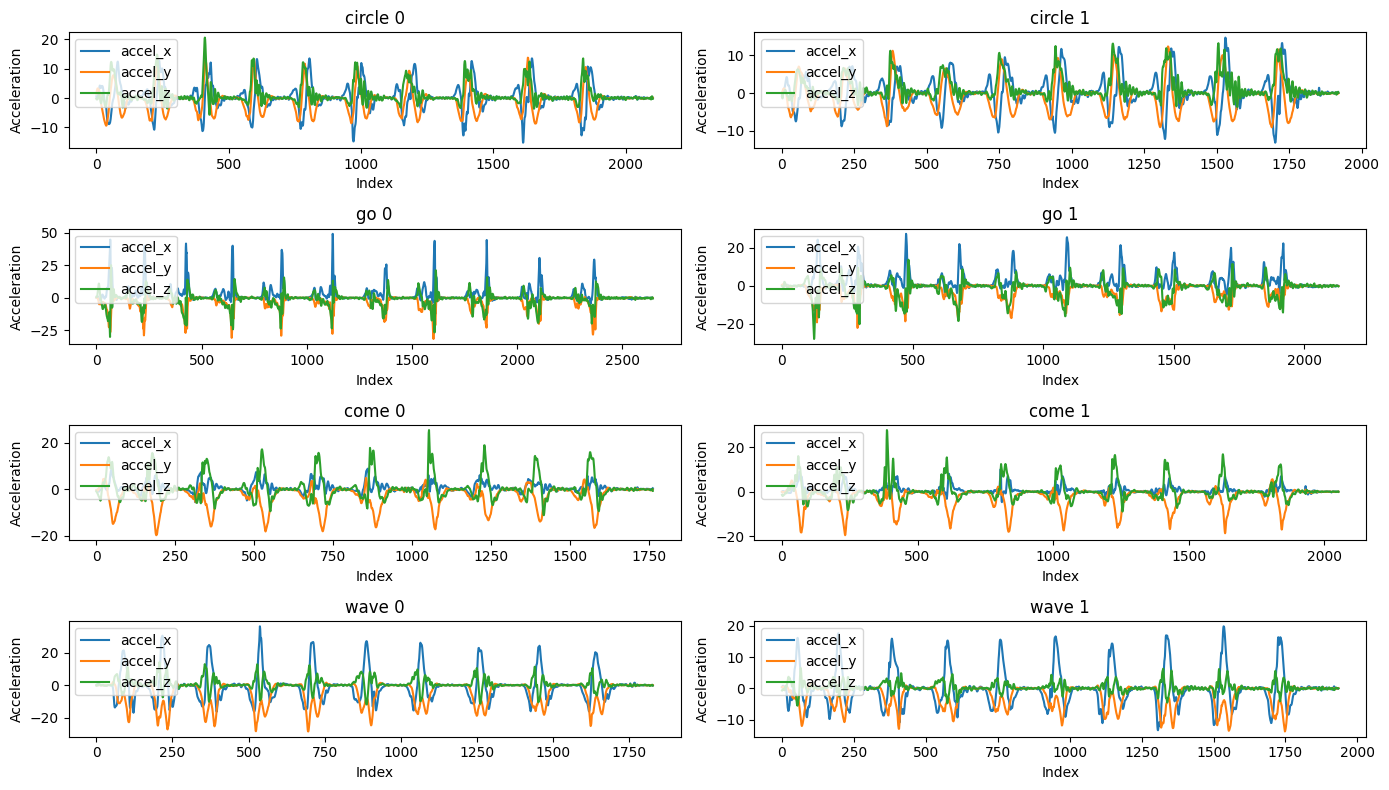

In [49]:
visualise_df(df, ['accel_x', 'accel_y', 'accel_z'], files_per_gesture=2)

### EWMA Filtering
To eradicate spikes in the data, we apply exponentially weighted moving average (EWMA)

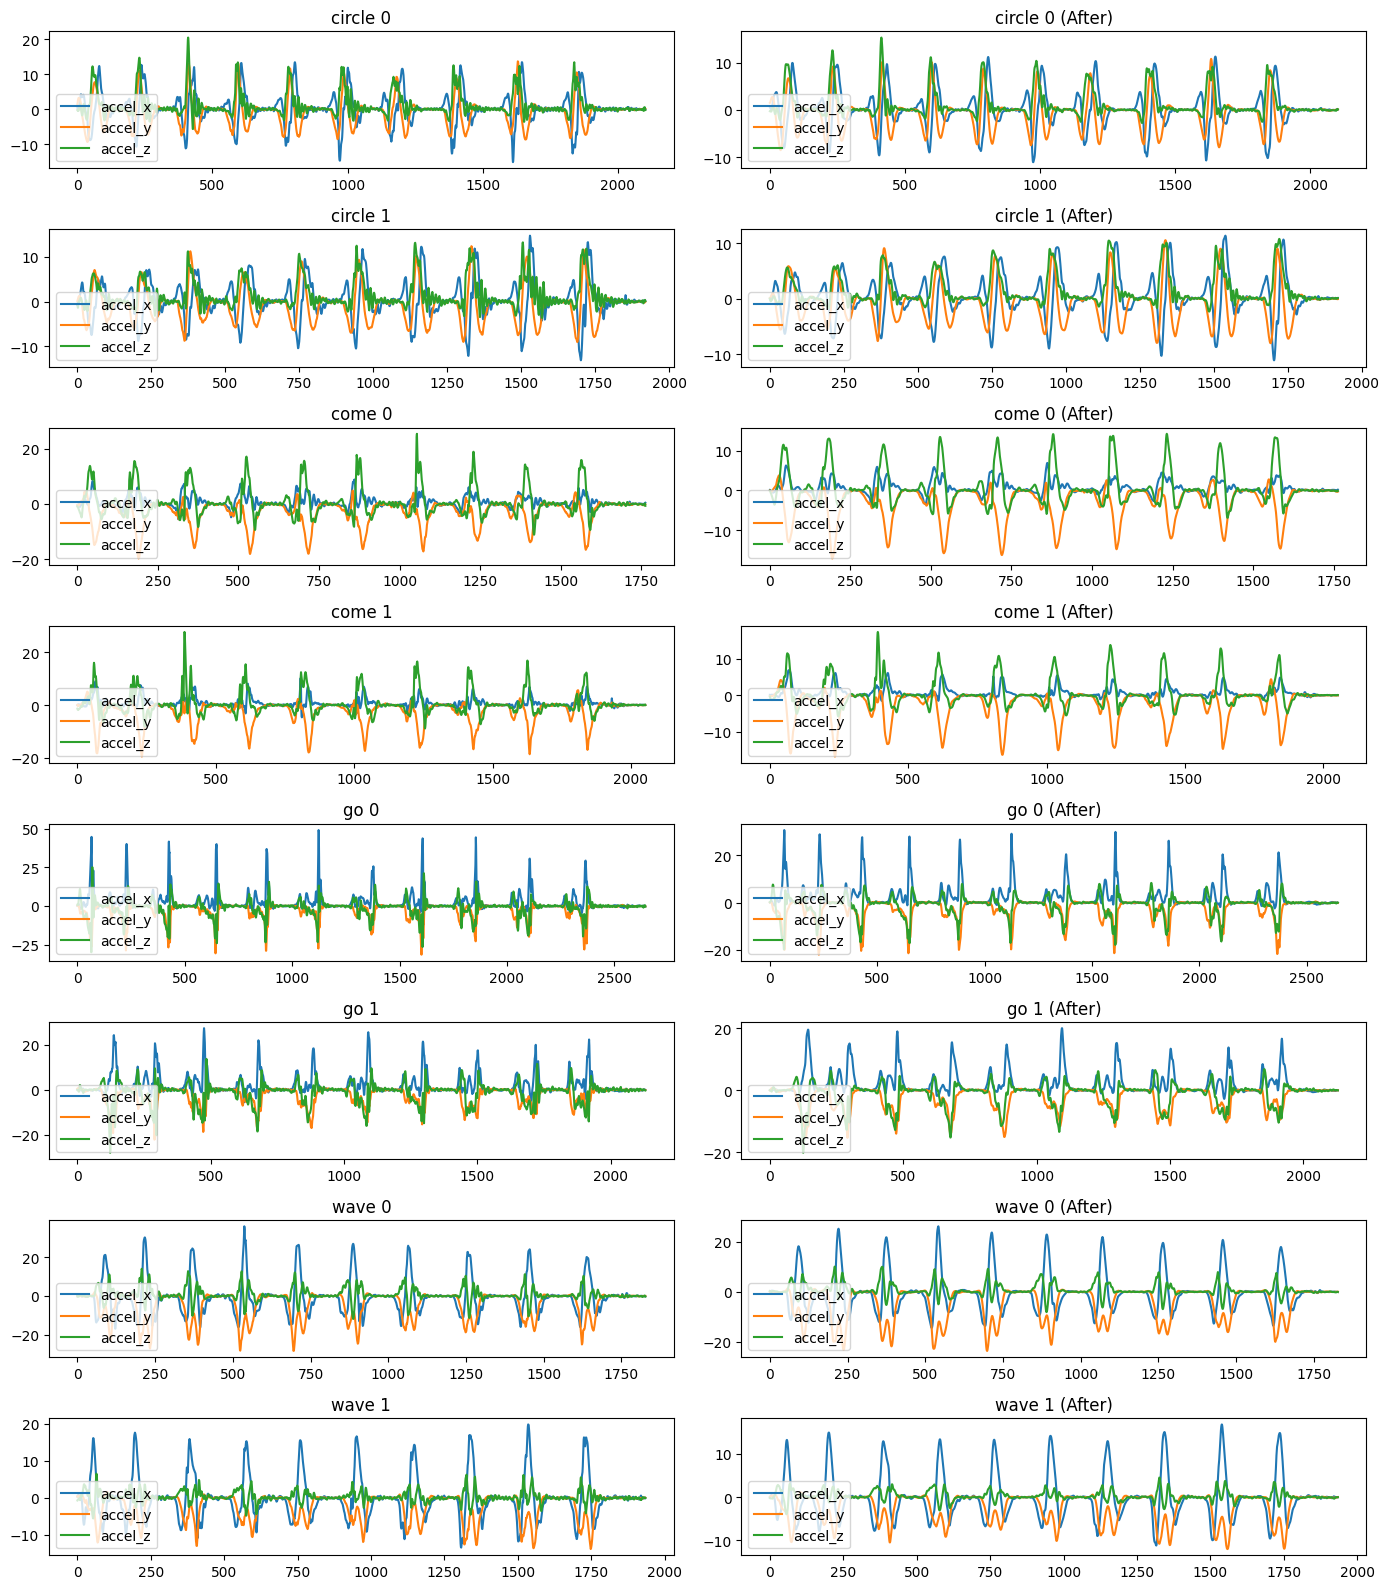

In [50]:
# Apply exponential moving average - Ashley Hunt - psyah10
ewm_filtered_df = df.ewm(span=10, adjust=False).mean()
compare_dfs(df, ewm_filtered_df, visualise_n=2)

In [51]:
df = ewm_filtered_df

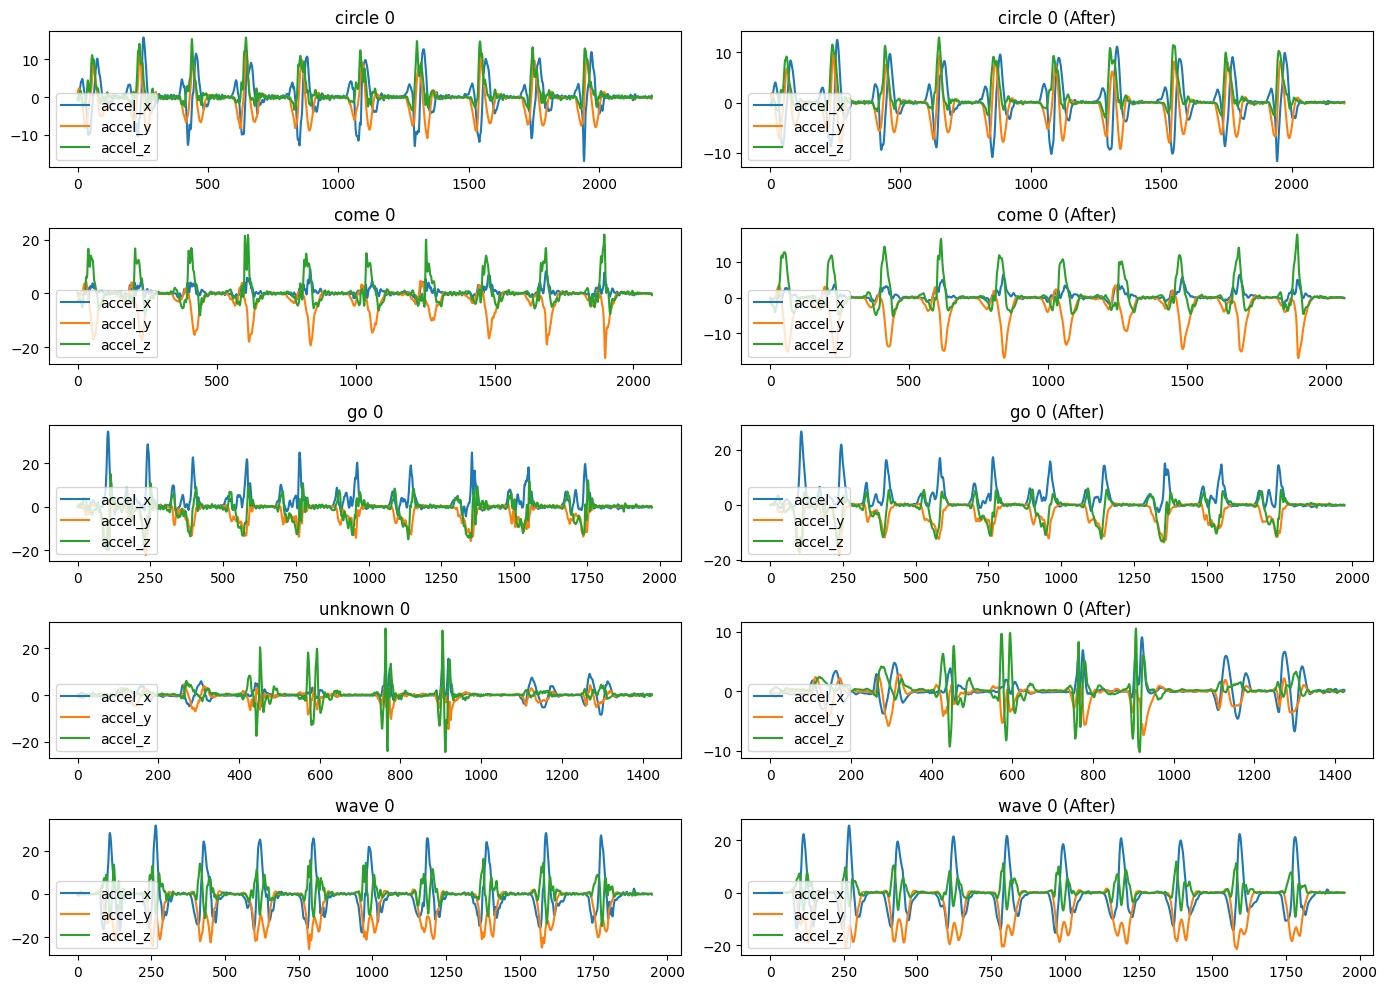

In [52]:
ewm_filtered_test_df = test_df.ewm(span=10, adjust=False).mean()
compare_dfs(test_df, ewm_filtered_test_df, visualise_n=1)

In [53]:
test_df = ewm_filtered_test_df

### Low-Pass Filtering
Next we apply a low-pass filter to reduce noise from the data and make our model more robust. First we visualise our data and using interactive widgets we visually evaluate the performance of different parameter settings for apply the filter.

In [54]:
# Low-pass filtering functions - Ashley Hunt - psyah10
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def apply_filter(df, cutoff_freq=2, fs=50, order=5):
    new_df = df.copy()
    for column in get_columns()[1:]:
        new_df[column] = butter_lowpass_filter(new_df[column], cutoff_freq, fs, order)
    return new_df

In [55]:
# Interactive filter parameter tuning - Ashley Hunt - psyah10
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display

cutoff_frequency_slider = widgets.IntSlider(value=3, min=1, max=15, step=1, description='cutoff_frequency')
sampling_rate_slider = widgets.IntSlider(value=150, min=10, max=150, step=1, description='sampling_rate')
filter_order_slider = widgets.IntSlider(value=3, min=1, max=15, step=1, description='filter_order')

def update_signal(cutoff_frequency, sampling_rate, filter_order):
    filtered_df = apply_filter(df, cutoff_frequency, sampling_rate, filter_order)
    compare_dfs(df, filtered_df, visualise_n=1)

interactive_plot = widgets.interactive(update_signal, cutoff_frequency=cutoff_frequency_slider, sampling_rate=sampling_rate_slider, filter_order=filter_order_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=3, description='cutoff_frequency', max=15, min=1), IntSlider(value=150, …

Using the best parameters we then apply these settings to our data

In [56]:
# Filter parameter tuning - Ashley Hunt - psyah10

cutoff_frequency = 3  # Cutoff frequency in Hz - Higher = less smoothing
sampling_rate = 150  # Sampling rate in Hz - Higher = more smoothing
filter_order = 5  # Filter order - Higher = less smoothing

df = apply_filter(df, cutoff_frequency, sampling_rate, filter_order)
test_df = apply_filter(test_df, cutoff_frequency, sampling_rate, filter_order)

### Gesture segmentation
Now we split the data from distinct files into distinct gestures. We do this by using the natural peaks and troughs in absolute acceleration.

In [57]:
# Spltting gestures functions - Ashley Hunt - psyah10
from scipy.signal import find_peaks

def split_file_to_gestures(df, threshold, padding, height, distance, width, prominence):
      gesture_data = []
      charts = []
      for (gesture, file_number), group in df.groupby(level=['gesture', 'file_number']):
            
            charts.append(gesture) ## Limit to 2 charts per gesture
            
            group.reset_index(drop=True, inplace=True)
            group.drop(['time'], axis=1, inplace=True)
            
            peaks, peak_info = find_peaks(group['accel_abs'], height=height, distance=distance, width=width, prominence=prominence)
            
            if(len(peaks) < 6 or len(peaks) > 10):
                  print(f"Incorrect peaks in {gesture} #{file_number} ({len(peaks)} peaks)")
                  plt.plot(group['accel_abs'])
                  plt.plot(peaks, group['accel_abs'][peaks], "x")
                  plt.title(f'{gesture} {file_number}')
                  plt.show()
            
            for peak in peaks:
                  
                  below_target = group.loc[:peak]
                  start_index = below_target[below_target['accel_abs'] < threshold].last_valid_index() #or 0
                  start_index = max(0, start_index - padding)
                  
                  above_target = group.loc[peak + 1:]
                  end_index = above_target[above_target['accel_abs'] < threshold].first_valid_index() #or len(group) - 1
                  end_index = min(len(group), end_index + padding)
                  
                  data = group.loc[start_index:end_index].copy()
                  
                  data['gesture_number'] = len(gesture_data)
                  data['gesture'] = gesture
                  gesture_data.append(data)
      
      gesture_df = pd.concat(gesture_data, ignore_index=True)
      gesture_df.set_index(['gesture', 'gesture_number'], inplace=True)
      return gesture_df

Incorrect peaks in come #4 (11 peaks)


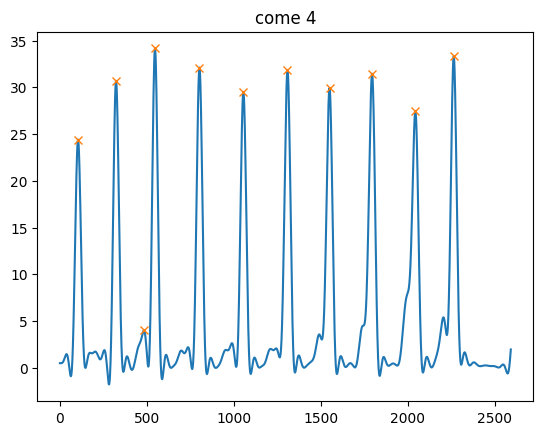

Incorrect peaks in go #0 (16 peaks)


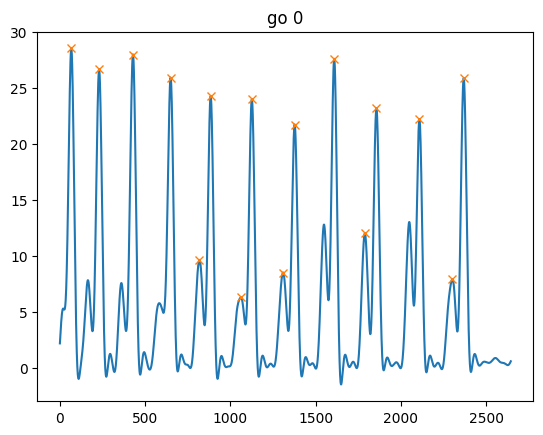

Incorrect peaks in wave #4 (11 peaks)


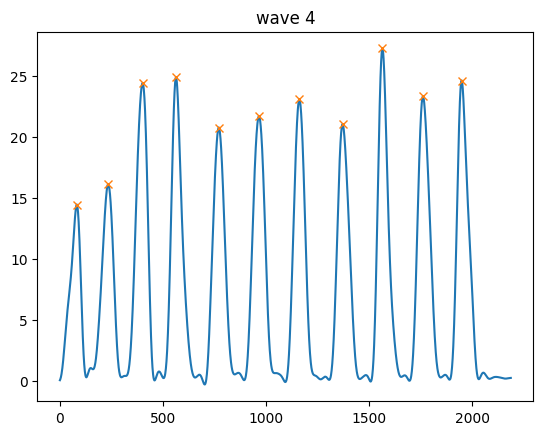

Incorrect peaks in go #0 (11 peaks)


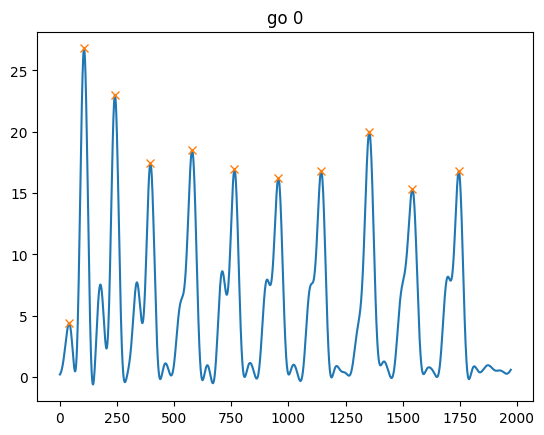

In [58]:
# Spltting gestures - Ashley Hunt - psyah10

# Parameters for splitting gestures, we adjust these to see which ones resulted in the best splitting

threshold=5
padding=10
height=3
distance=20
width=30
prominence=0

gesture_df = split_file_to_gestures(df, threshold, padding, height, distance, width, prominence)
test_gesture_df = split_file_to_gestures(test_df, threshold, padding, height, distance, width, prominence)

Now we visualise these gestures.

In [59]:
# Visualising gesture functions - Ashley Hunt - psyah10

def visualise_gestures(dataframe, n):
      
      num_gestures = dataframe.index.get_level_values('gesture').unique().size
      
      charts = []
      plt.figure(figsize=(n * num_gestures, 10))
      for (gesture, gesture_number), group in dataframe.groupby(level=['gesture', 'gesture_number']):
            
            charts.append(gesture) ## Limit charts per gesture
            if(charts.count(gesture) > n):
                  continue
            
            gesture_i = len(pd.Series(charts).unique()) - 1
            plt.subplot(num_gestures, n, (n * gesture_i ) + charts.count(gesture) )
            
            group.reset_index(drop=True, inplace=True)
            for col in get_columns()[1:4]:
                  plt.plot(range(len(group)), group[col], label=col)
                  plt.title("{gesture} {gesture_number}".format(gesture=gesture, gesture_number=gesture_number))
                  plt.legend()
                  # plt.ylim(0, 1)
      plt.subplots_adjust(hspace=0.4)
      plt.show()

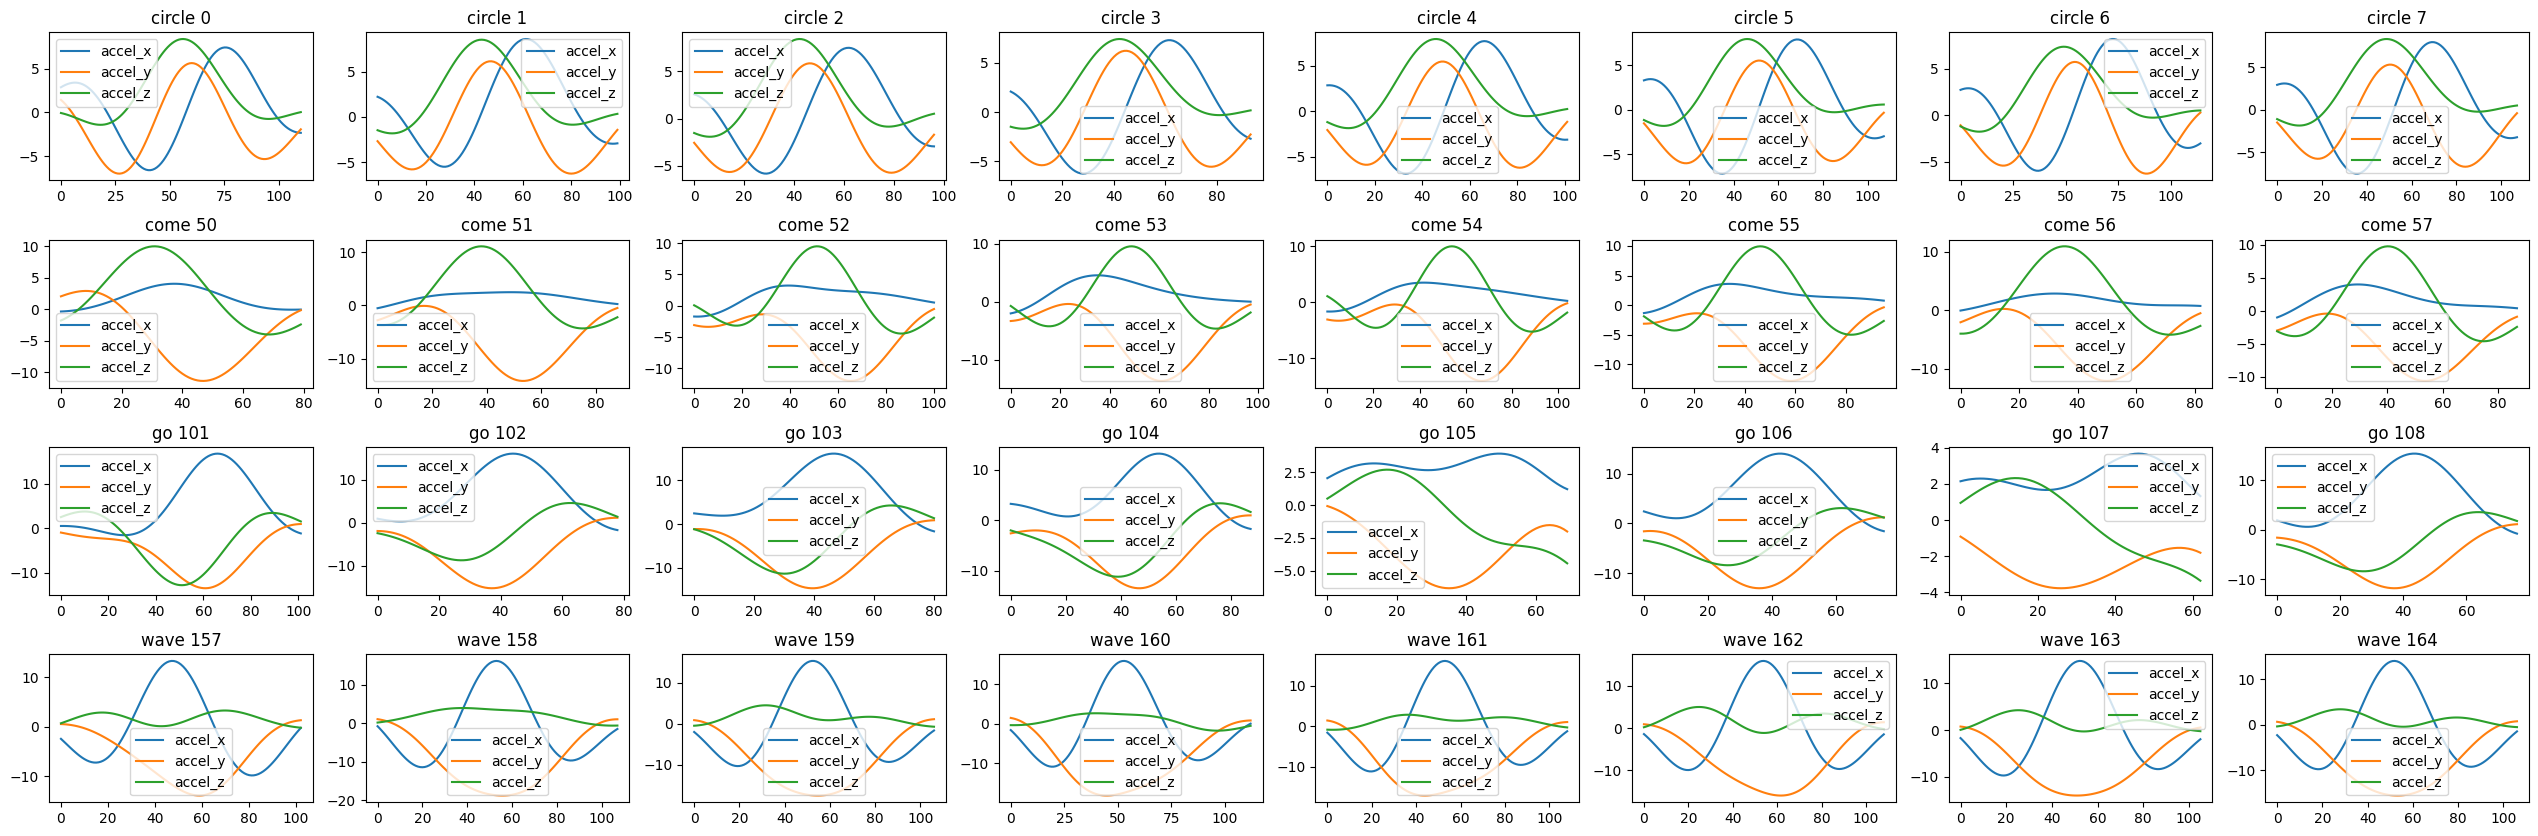

In [60]:
# Visualising data - Ashley Hunt - psyah10

visualise_gestures(gesture_df, 8)

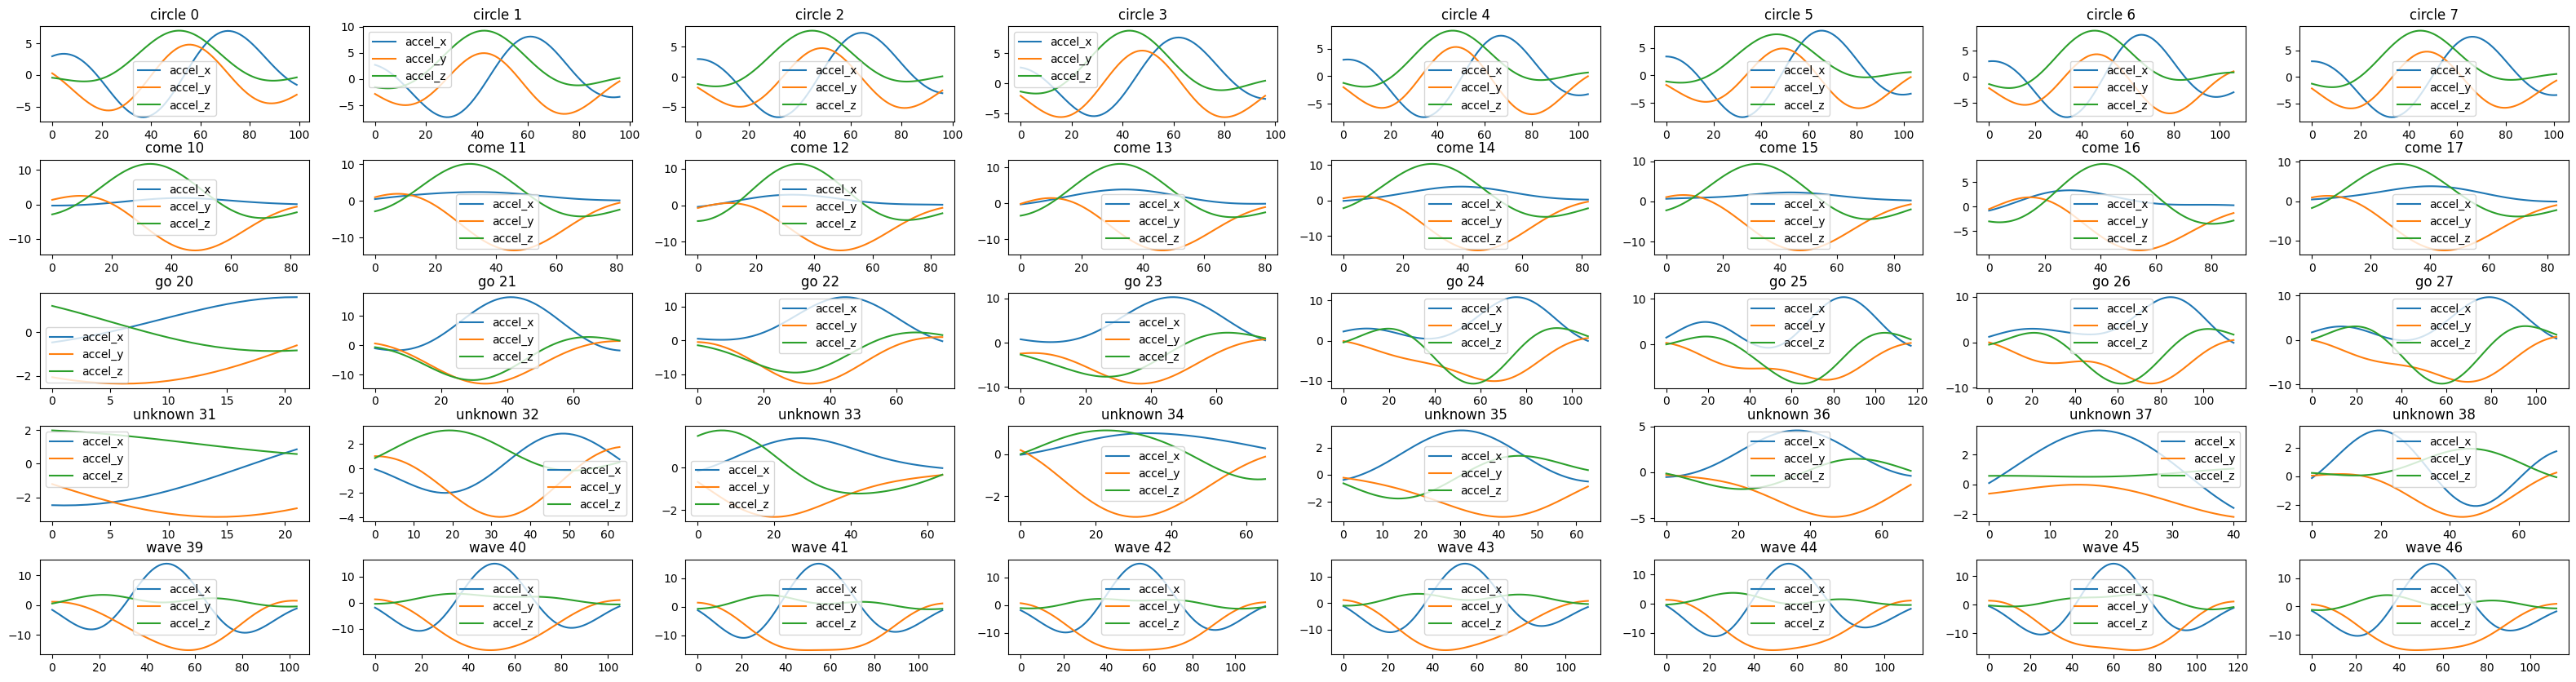

In [61]:
# Visualising test data - Ashley Hunt - psyah10

visualise_gestures(test_gesture_df, 8)

If, due to slicing errors, there are duplicate gestures we will remove them

In [62]:
# Removing duplicate functions - Ashley Hunt - psyah10

def remove_duplicate_gestures(dataframe):
      data = dataframe.copy()
      
      data_columns = get_columns()[1:]
      group_columns = ['gesture', 'gesture_number']

      grouped = data.groupby(group_columns)

      group_representations = {}
      duplicates_found = False
      for name, group in grouped:
            group_tuple = tuple(group.sort_values(by=data_columns)[data_columns].itertuples(index=False, name=None))
            
            if group_tuple in group_representations:
                  duplicates_found = True
                  data = data.drop(name)
                  print("Removing identical gestures", name, "and", group_representations[group_tuple])
            group_representations[group_tuple] = name
            
      if not duplicates_found:
            print("No duplicate gestures found")
      return data

In [63]:
# Removing duplicate slices - Ashley Hunt - psyah10

gesture_df = remove_duplicate_gestures(gesture_df)
test_gesture_df = remove_duplicate_gestures(test_gesture_df)

No duplicate gestures found
No duplicate gestures found


### Fourier Transformation & Filtering
Next we apply a Fourier transformation on the data and filter out the frequencies in the data that are not adding useful information. This is achieved using trial and error through visualisation of the wave before and after transformation.

In [64]:
# Fourier Transformation functions - Ashley Hunt - psyah10
import numpy as np

def fft_filter(data, sample_rate, cutoff_freq_low, cutoff_freq_high):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data), 1/sample_rate)

    mask = (freqs > cutoff_freq_low) & (freqs < cutoff_freq_high)
    fft_data[~mask] = 0

    filtered_signal = np.fft.ifft(fft_data).real
    return filtered_signal

def apply_fft_filter(data, sample_rate, cutoff_freq_low, cutoff_freq_high):
    new_df = data.copy()
    for column in get_columns()[1:4]:
        new_df[column] = fft_filter(new_df[column], sample_rate, cutoff_freq_low, cutoff_freq_high)
    return new_df

In [65]:
# Fourier Transformation - Ashley Hunt - psyah10
 
sample_rate = 1000  # Sampling rate (Hz)
cutoff_low = 2  # Low cutoff frequency (Hz)
cutoff_high = 50  # High cutoff frequency (Hz)

fft_filtered_gestures_df = apply_fft_filter(gesture_df, sample_rate, cutoff_low, cutoff_high)
fft_test_filtered_gestures_df = apply_fft_filter(test_gesture_df, sample_rate, cutoff_low, cutoff_high)

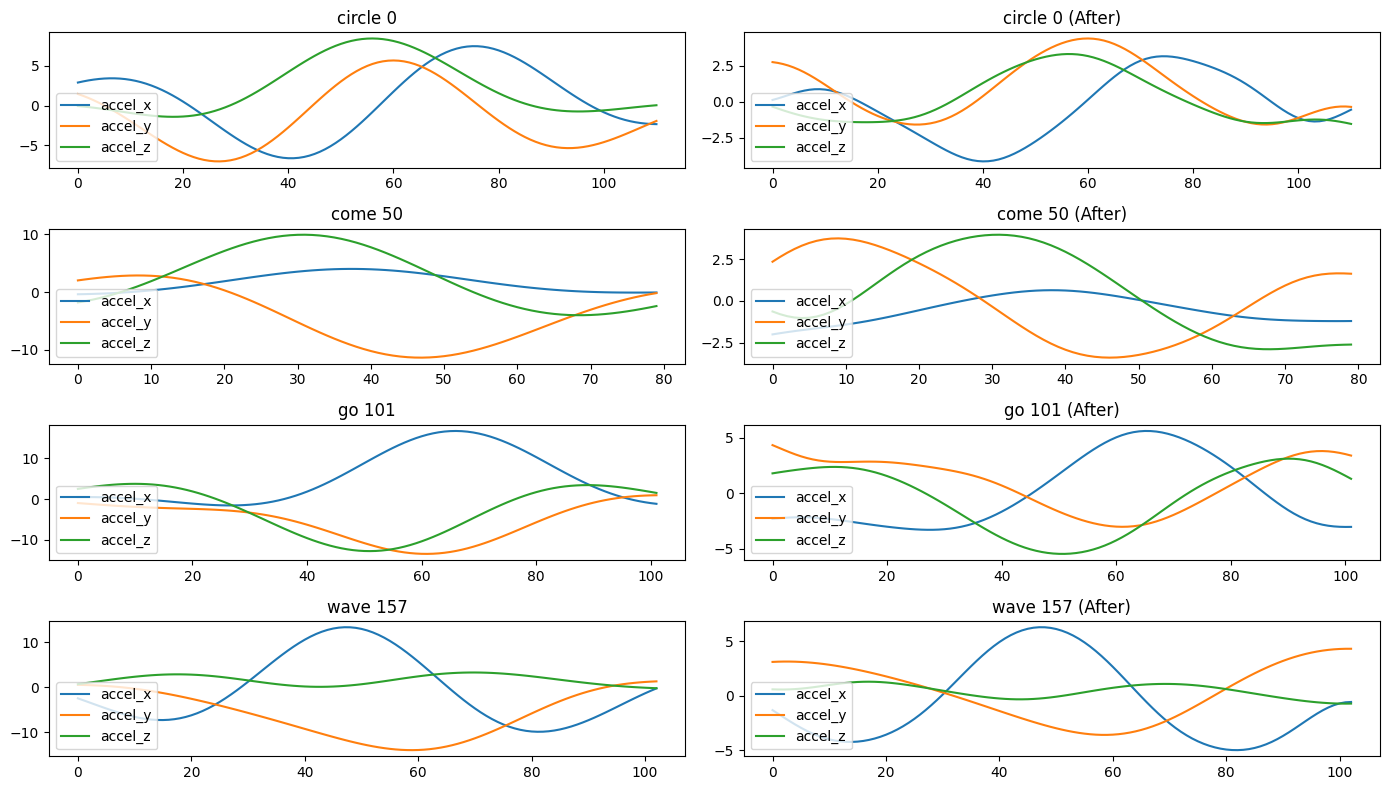

In [66]:
compare_dfs(gesture_df, fft_filtered_gestures_df, visualise_n=1)

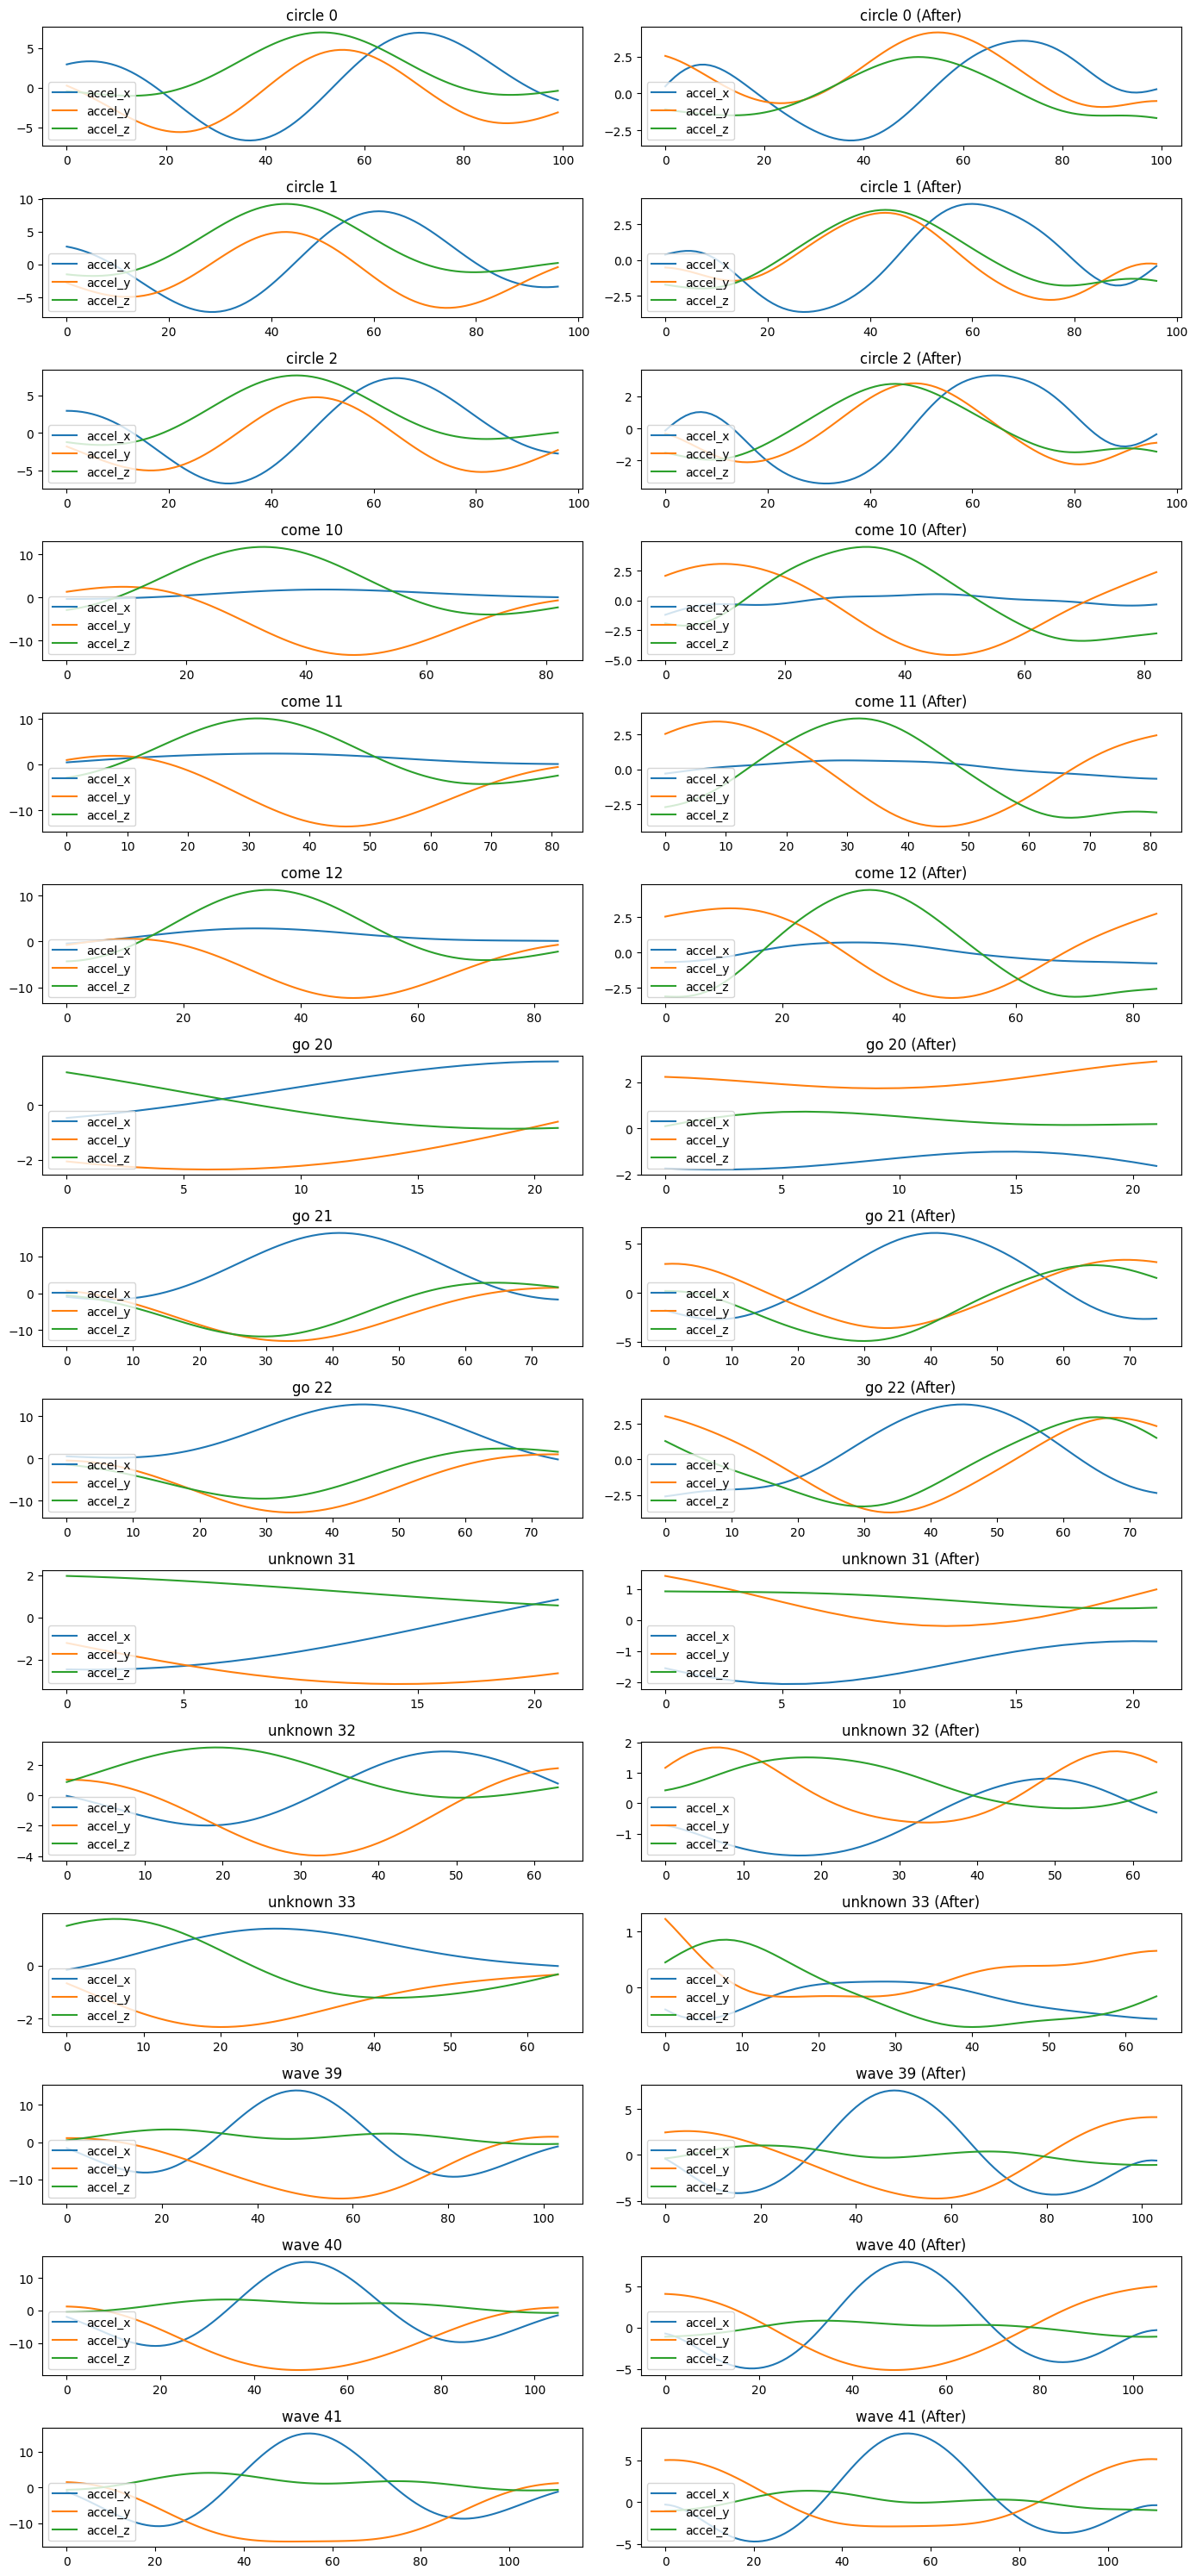

In [67]:
# Visualise the FFT filter alongside the original data (test data)
compare_dfs(test_gesture_df, fft_test_filtered_gestures_df, 3)

### Data Normalisation

At this point we also normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1. This will ensure that no single field plays a more important role than it should.

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() ## StandardScaler() or MinMaxScaler()

gesture_df[gesture_df.columns] = scaler.fit_transform(gesture_df[gesture_df.columns])
test_gesture_df[test_gesture_df.columns] = scaler.fit_transform(test_gesture_df[test_gesture_df.columns])

## Feature Extraction
Next we can begin to extract our features for the models. These functions split the data into a fixed number of segments with some overlap and then take some key statistical values from these slices.

In [69]:
# Feature extraction functions - Ashley Hunt - psyah10

def extract_segments(df, num_segments, overlap_fraction):
    total_rows = len(df)
    segment_size = total_rows // num_segments
    overlap_size = int(segment_size * overlap_fraction)
    
    segments = []
    
    for i in range(num_segments):
        start_idx = i * segment_size
        if i > 0:
            start_idx -= overlap_size
        
        if i == num_segments - 1:
            end_idx = total_rows
        else:
            end_idx = start_idx + segment_size + overlap_size

        segments.append(df.iloc[start_idx:end_idx])
    
    return segments

def extract_features_from_df(df, feature_functions, num_segments = 4, overlap_fraction = 0.1):
      results = []
      
      for (gesture, gesture_number), group in df.groupby(level=['gesture', 'gesture_number']):
            
            group.reset_index(drop=True, inplace=True)

            result_dict = {}
            segments = extract_segments(group, num_segments, overlap_fraction)
            result_dict['gesture'] = gesture
            for n, segment in enumerate(segments):
                  for col in get_columns()[1:4]:
                        for f in feature_functions:
                              result_dict[f'{col}_{f}_{n+1}'] = segment[col].agg(f)

            results.append(result_dict)

      return pd.DataFrame(results)

In [70]:
# Feature extraction - Ashley Hunt - psyah10

# Function options 'mean', 'min', 'max', 'median', 'std', 'skew', 'kurtosis', 'quantile'
feature_functions = ['mean', 'min', 'max', 'median', 'std', 'skew', 'kurtosis', 'quantile'] 
num_segments = 8
overlap_fraction = 0.3

# If using FFT filtered data
# extracted_features = extract_features_from_df(fft_filtered_gestures_df, feature_functions, num_segments, overlap_fraction)
# extracted_test_features = extract_features_from_df(fft_test_filtered_gestures_df, feature_functions, num_segments, overlap_fraction)

extracted_features = extract_features_from_df(gesture_df, feature_functions, num_segments, overlap_fraction)
extracted_test_features = extract_features_from_df(test_gesture_df, feature_functions, num_segments, overlap_fraction)

In [71]:
extracted_features.dropna(how='any', inplace=True)
extracted_test_features.dropna(how='any', inplace=True)

In [72]:
extracted_features

gesture  accel_x_mean_1  accel_x_min_1  accel_x_max_1  accel_x_median_1  \
0    circle        0.506686       0.477299       0.518388          0.510398   
1    circle        0.417940       0.334239       0.476964          0.425817   
2    circle        0.431857       0.346919       0.488428          0.440882   
3    circle        0.413061       0.332677       0.471658          0.419952   
4    circle        0.465229       0.396014       0.499007          0.476522   
..      ...             ...            ...            ...               ...   
203    wave        0.571138       0.439134       0.706067          0.569940   
204    wave        0.578806       0.435205       0.720736          0.578829   
205    wave        0.602897       0.447555       0.761385          0.601583   
206    wave        0.578663       0.421325       0.756506          0.571968   
207    wave        0.600570       0.435222       0.774598          0.597433   

     accel_x_std_1  accel_x_skew_1  accel_x_kurtosis_1  accel_x_quantile_1  \
0         0.012141       -1.219967            0.933463            0.510398   
1         0.047008       -0.426152           -1.103383            0.425817   
2         0.046751       -0.489553           -1.044583            0.440882   
3         0.045822       -0.397903           -1.110776            0.419952   
4         0.034521       -0.812833           -0.588957            0.476522   
..             ...             ...                 ...                 ...   
203       0.087445        0.030690           -1.312905            0.569940   
204       0.093703       -0.006749           -1.343867            0.578829   
205       0.102841        0.028359           -1.314150            0.601583   
206       0.108992        0.148567           -1.292369            0.571968   
207       0.110656        0.065163           -1.320329            0.597433   

     accel_y_mean_1  ...  accel_y_kurtosis_8  accel_y_quantile_8  \
0          0.724792  ...           -0.635729            0.617811   
1          0.623707  ...           -1.262709            0.627719   
2          0.627733  ...           -1.244041            0.638115   
3          0.623518  ...           -0.730820            0.613448   
4          0.636334  ...           -1.279878            0.628275   
..              ...  ...                 ...                 ...   
203        0.756295  ...           -0.649670            0.753553   
204        0.749788  ...           -0.610345            0.763198   
205        0.771817  ...           -0.554773            0.765490   
206        0.792220  ...           -0.526136            0.752193   
207        0.779415  ...           -0.606909            0.754444   

     accel_z_mean_8  accel_z_min_8  accel_z_max_8  accel_z_median_8  \
0          0.471824       0.461116       0.490462          0.469891   
1          0.477668       0.457029       0.502018          0.476768   
2          0.484632       0.460744       0.508288          0.484824   
3          0.483896       0.477264       0.495439          0.482774   
4          0.480133       0.468857       0.498365          0.477533   
..              ...            ...            ...               ...   
203        0.611206       0.553113       0.639682          0.621967   
204        0.580229       0.543649       0.598807          0.586166   
205        0.540208       0.523487       0.547396          0.542551   
206        0.587170       0.557563       0.599829          0.592118   
207        0.602032       0.539358       0.645262          0.607715   

     accel_z_std_8  accel_z_skew_8  accel_z_kurtosis_8  accel_z_quantile_8  
0         0.009363        0.593632           -0.871253            0.469891  
1         0.015474        0.144188           -1.439451            0.476768  
2         0.015927       -0.020757           -1.383711            0.484824  
3         0.005800        0.576788           -0.903687            0.482774  
4         0.010307        0.481635           -1.289654         

In [73]:
from itertools import cycle
# For each 'uknown' gesture in extracted_test_features replace with gestures from get_gestures() in a cycle

repeats_in_tests = 2
repeated = [element for element in get_gestures() for _ in range(repeats_in_tests)]
unknown_indices = extracted_test_features.index[extracted_test_features['gesture'] == 'unknown'].tolist()

gesture_cycle = cycle(repeated)
replacements = [next(gesture_cycle) for _ in range(len(unknown_indices))]

for index, replacement in zip(unknown_indices, replacements):
    extracted_test_features.at[index, 'gesture'] = replacement

## Feature Selection
Now we visulaise the extracted features to help us determine which features are most useful in classification.

In [74]:
# Visualisting Feature extraction functions - Ashley Hunt - psyah10

def show_trends(dataframe):
      for f in feature_functions:
            plt.figure(figsize=(15, 3))
            for col in get_columns()[1:4]:
                  plt.subplot(1, 3, get_columns().index(col))
                  plt.title(col)
                  for g in get_gestures():
                        points = []
                        for s in range(1, num_segments + 1):
                              points.append( dataframe.loc[dataframe["gesture"] == g][f'{col}_{f}_{s}'].mean())
                        plt.plot(range(1, num_segments + 1), points, marker='o', linestyle='-', label=g)
                        plt.xlabel('Segment')
                        plt.ylabel(f)
                        plt.legend()
                        plt.xticks(range(1, num_segments + 1))
            plt.suptitle(f"{f} by segment")
            plt.tight_layout()
            plt.show()

### Feature visualisation

In [75]:
# Visualisting Feature extraction for feature selection - Ashley Hunt - psyah10

# show_trends(extracted_features)

In [76]:
# Visualisting individual feature extraction for selection - Ashley Hunt - psyah10

def show_trend(dataframe, function, charts_per_gesture=4):
      
      for g in get_gestures():
            if len(dataframe.loc[dataframe["gesture"] == g]) == 0:
                  continue
            plt.figure(figsize=(charts_per_gesture * 4, 3))
            plt.title(f"{charts_per_gesture} {g}'s {function}")
            for graphs in range(0, charts_per_gesture):
                  plt.subplot(1, charts_per_gesture, graphs + 1)
                  
                  data = dataframe.loc[dataframe["gesture"] == g].iloc[graphs]
                  for col in get_columns()[1:4]:
                        points = []
                        for s in range(1, num_segments + 1):
                              points.append(data[f'{col}_{function}_{s}'])
                        plt.plot(range(1, num_segments + 1), points, marker='o', linestyle='-', label=col)
                  plt.legend()
                  plt.xticks(range(1, num_segments + 1))
            plt.tight_layout()
            plt.show()

In [77]:
# Visualisting Feature extraction for feature selection - Ashley Hunt - psyah10

# for f in feature_functions:
#       show_trend(extracted_features, f, 2)

### Rebalance data
Once again we reblance our data, this time on the total number of observations for each gesture.

In [78]:
# Balance data functions - Ashley Hunt - psyah10

def rebalance_data(dataframe):
      # Find out the minimum number of gestures in a category
      min_gestures = dataframe['gesture'].value_counts().min()

      # Take only the top x gestures
      return dataframe.groupby('gesture').head(min_gestures)


In [79]:
# Re-balance data - Ashley Hunt - psyah10

extracted_features = rebalance_data(extracted_features)

In [80]:
# Principle Component Analysis & Extraction functions - Ashley Hunt - psyah10

from sklearn.decomposition import PCA
import seaborn as sns

def extract_principle_components(dataframe, components=2):
      
      data = dataframe.reset_index()
      gestures = data['gesture']
      data = data.loc[:, (data.columns != 'gesture') & (data.columns != 'index')]

      pca = PCA(n_components=components)
      principal_components = pca.fit_transform(data)
      cols = [f'principal component {i}' for i in range(1, components + 1)]
      principle_df = pd.DataFrame(data = principal_components, columns = cols)
      principle_df['gesture'] = gestures

      return principle_df

def visualise_principle_components(dataframe):
      cols = len(dataframe.columns) - 1
      plt.figure(figsize=(cols * 3, cols * 3))
      sns.pairplot(dataframe, hue="gesture", palette="deep")
      plt.show()

### Principle Component Analysis

We then utilise PCA to do automatic feature selection. This is easy to extract and does not rely on subjective human input.

In [81]:
# Principle Component Analysis & Extraction - Ashley Hunt - psyah10

NUM_PCA_COMPONENTS = 3

principle_features = extract_principle_components(extracted_features, components=NUM_PCA_COMPONENTS)
test_principle_features = extract_principle_components(extracted_test_features, components=NUM_PCA_COMPONENTS)

<Figure size 900x900 with 0 Axes>

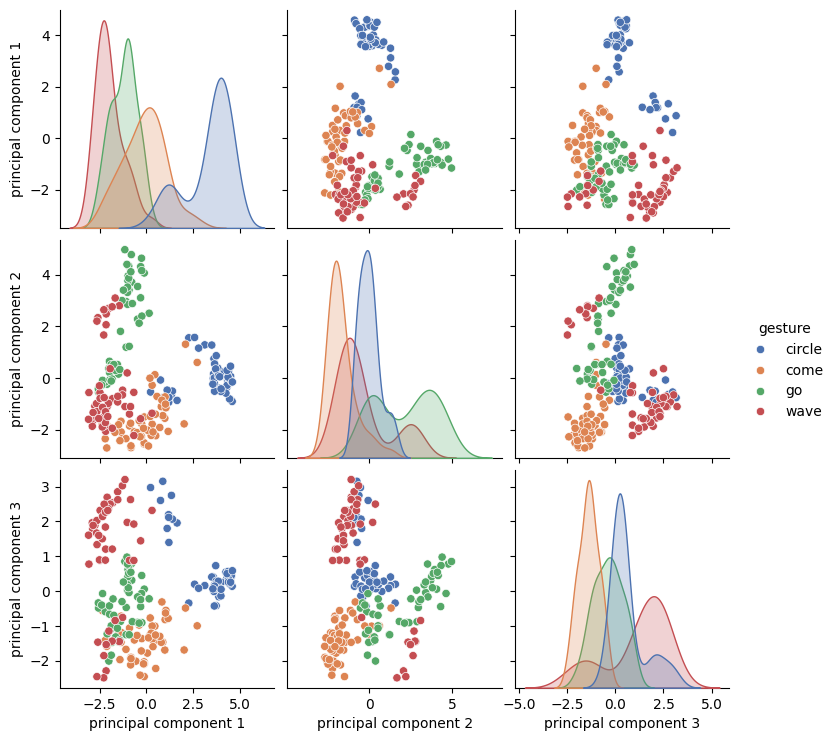

In [82]:
# Visualising Principle Component Analysis - Ashley Hunt - psyah10
visualise_principle_components(principle_features)

<Figure size 900x900 with 0 Axes>

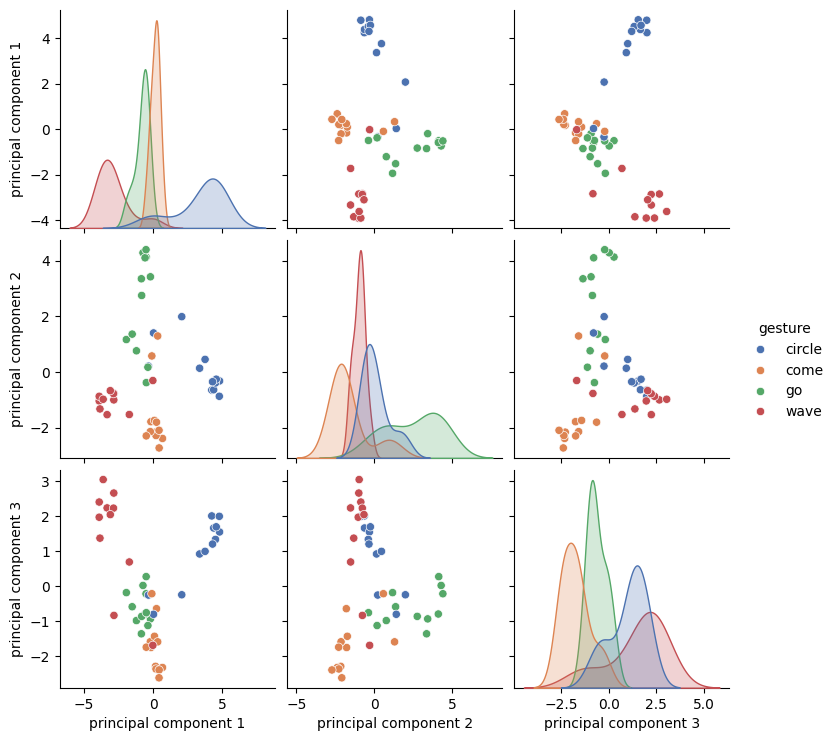

In [83]:
# Visualising Principle Component Analysis - Ashley Hunt - psyah10
visualise_principle_components(test_principle_features)

## Model Training
First we prepare out label encoder

In [84]:
# Label encoding functions - Ashley Hunt - psyah10
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def encode_labels(labels):
    return label_encoder.fit_transform(labels)

def decode_labels(encoded_labels):
    return label_encoder.inverse_transform(encoded_labels)

Then we extract the data that we need

In [85]:
# Data splitting - Ashley Hunt - psyah10
from sklearn.model_selection import train_test_split

PRINCIPLE = True

if PRINCIPLE:
      X = principle_features.loc[:, principle_features.columns != 'gesture']
      Y = encode_labels(principle_features['gesture'])
      UNSEEN_FEATURES = test_principle_features.loc[:, test_principle_features.columns != 'gesture']
      UNSEEN_LABELS = encode_labels(test_principle_features['gesture'])
else:
      X = extracted_features.loc[:, extracted_features.columns != 'gesture']
      Y = encode_labels(extracted_features['gesture'])
      UNSEEN_FEATURES = extracted_test_features.loc[:, extracted_test_features.columns != 'gesture']
      UNSEEN_LABELS = encode_labels(extracted_test_features['gesture'])

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.3, random_state=42)

### K-means Clustering
As the first, most basic, option for classification we consider a K-means clustering algorithm.

In [86]:
# K-means clustering functions - Ashley Hunt - psyah10

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = num_gestures()

kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_model.fit(train_features)

KMeans(n_clusters=4, random_state=42)

In [87]:
# K-means clustering visualisation - Ashley Hunt - psyah10

def visualise_kmeans(dataframe, model):
      kmeans_data = dataframe.copy()
      kmeans_data['Cluster'] = model.fit_predict(dataframe)
      kmeans_data['Gesture'] = decode_labels(train_labels)

      sns.scatterplot( data = kmeans_data, x='principal component 1', y='principal component 2', hue='Gesture', palette='viridis', style='Cluster', s=100)
      plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='red', s=100, alpha=0.5, label='Centroids')
      plt.title('K-means Clustering on PCA-Reduced Data')
      plt.xlabel('principal component 1')
      plt.ylabel('principal component 2')
      plt.legend()
      plt.show()

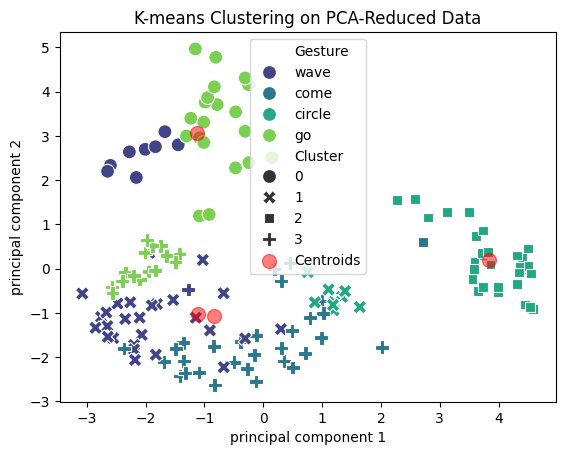

In [88]:
visualise_kmeans(train_features, kmeans_model)

In [89]:
# Testing/Validation display functions - Ashley Hunt - psyah10

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def show_confusion_matrix(actual, predictions):
      
      fig, ax = plt.subplots(figsize=(8, 6))
      
      labels = decode_labels(unique_labels(actual))
      cm_df = pd.DataFrame(confusion_matrix(actual, predictions), index=labels, columns=labels)

      # plt.figure(figsize=(7, 5))
      sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', cbar=True, square=True, linewidth=.5, ax=ax)
      
      # Loop over the data dimensions and outline the diagonal cells
      for i in range(cm_df.shape[0]):
            for j in range(cm_df.shape[1]):
                  if i == j: 
                        rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='green', lw=1)
                        ax.add_patch(rect)
      
      plt.title('Confusion Matrix')
      plt.ylabel('Actual', labelpad=20)
      plt.xlabel('Predicted', labelpad=20)
      plt.tight_layout()
      plt.show()
      
def show_classification_report(actual, predictions):
      print(f"Accuracy: {accuracy_score(actual, predictions)}")
      print(classification_report(actual, predictions))

In [90]:
# K-means Evaluation - Ashley Hunt - psyah10
kmeans_predictions = kmeans_model.predict(test_features)
print('Silhouette Score:', silhouette_score(test_features, kmeans_predictions))
show_classification_report(test_labels, kmeans_predictions)

Silhouette Score: 0.5775352991124127
Accuracy: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      11.0
           1       0.00      0.00      0.00      20.0
           2       0.00      0.00      0.00      15.0
           3       0.00      0.00      0.00      14.0

    accuracy                           0.00      60.0
   macro avg       0.00      0.00      0.00      60.0
weighted avg       0.00      0.00      0.00      60.0



Accuracy: 0.06382978723404255
              precision    recall  f1-score   support

           0       0.09      0.08      0.09        12
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        12
           3       0.12      0.18      0.14        11

    accuracy                           0.06        47
   macro avg       0.05      0.07      0.06        47
weighted avg       0.05      0.06      0.06        47



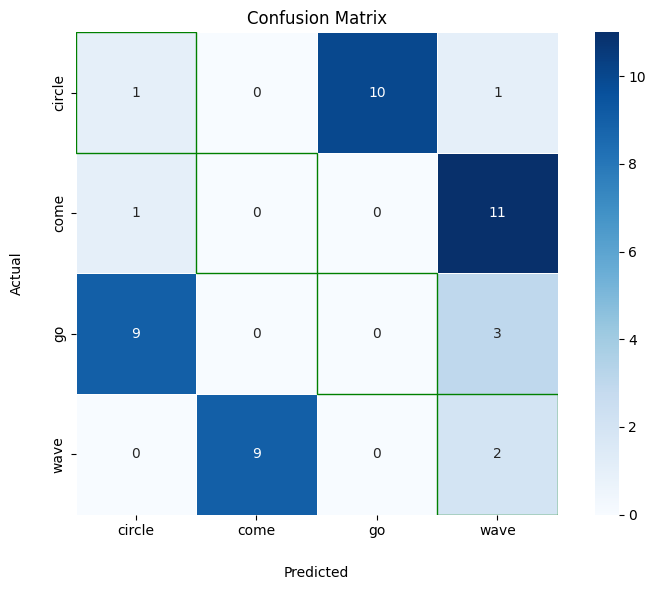

In [91]:
# K-means Validation - Ashley Hunt - psyah10

kmeans_prediction = kmeans_model.predict(UNSEEN_FEATURES)

show_classification_report(UNSEEN_LABELS, kmeans_prediction)
show_confusion_matrix(UNSEEN_LABELS, kmeans_prediction)

### Random Forest

In [92]:
# Random Forest Training - Ashley Hunt - psyah10
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [93]:
# Random Forest Evaluation - Ashley Hunt - psyah10

rfc_prediction = rfc_model.predict(test_features)

show_classification_report(test_labels, rfc_prediction)

Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       1.00      0.95      0.97        20
           2       1.00      1.00      1.00        15
           3       0.93      1.00      0.97        14

    accuracy                           0.97        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.97      0.97      0.97        60



In [94]:
# Random Forest Hypertuning  Ashley Hunt - psyah10
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=80

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [95]:
# Random Forest Hypertuning  Ashley Hunt - psyah10
from sklearn.metrics import balanced_accuracy_score

rf_best_params = rf_random.best_params_
rf_best_estimator = rf_random.best_estimator_

rf_predictions = rf_best_estimator.predict(test_features)
balanced_accuracy = balanced_accuracy_score(test_labels, rf_predictions)

print("Best Parameters:", rf_best_params)
print("Balanced Accuracy:", balanced_accuracy)

Best Parameters: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}
Balanced Accuracy: 0.9647727272727272


Accuracy: 0.9148936170212766
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.92      0.92      0.92        12
           2       0.80      1.00      0.89        12
           3       1.00      0.91      0.95        11

    accuracy                           0.91        47
   macro avg       0.93      0.91      0.92        47
weighted avg       0.93      0.91      0.92        47



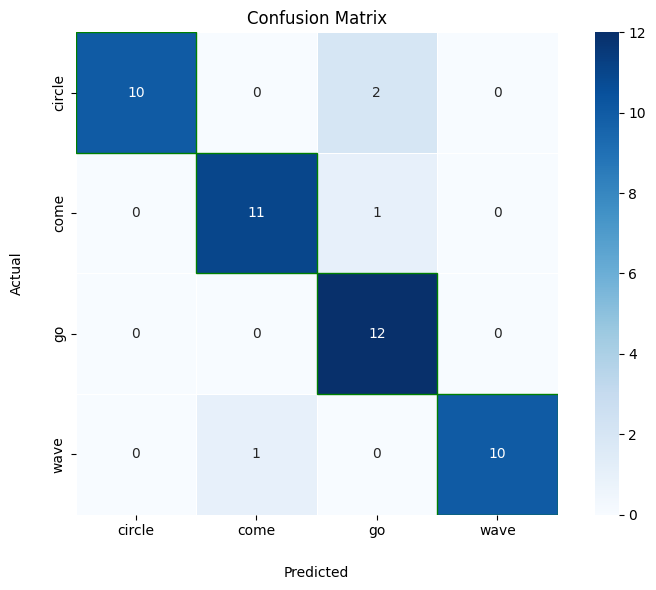

In [96]:
# Random Forest Validation - Ashley Hunt - psyah10
rfc_unseen_feature_prediction = rf_best_estimator.predict(UNSEEN_FEATURES)

show_classification_report(UNSEEN_LABELS, rfc_unseen_feature_prediction)
show_confusion_matrix(UNSEEN_LABELS, rfc_unseen_feature_prediction)

### Support Vector Machines 

In [97]:
# Support Vector Machines Training - Ashley Hunt - psyah10
from sklearn import svm

svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_features, train_labels)

SVC(kernel='linear')

In [98]:
# Support Vector Machines Evaluation - Ashley Hunt - psyah10
svm_prediction = svm_model.predict(test_features)

show_classification_report(test_labels, svm_prediction)

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.95      0.97        20
           2       0.88      1.00      0.94        15
           3       1.00      0.86      0.92        14

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



Accuracy: 0.851063829787234
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.73      0.92      0.81        12
           2       0.77      0.83      0.80        12
           3       1.00      0.82      0.90        11

    accuracy                           0.85        47
   macro avg       0.88      0.85      0.86        47
weighted avg       0.87      0.85      0.86        47



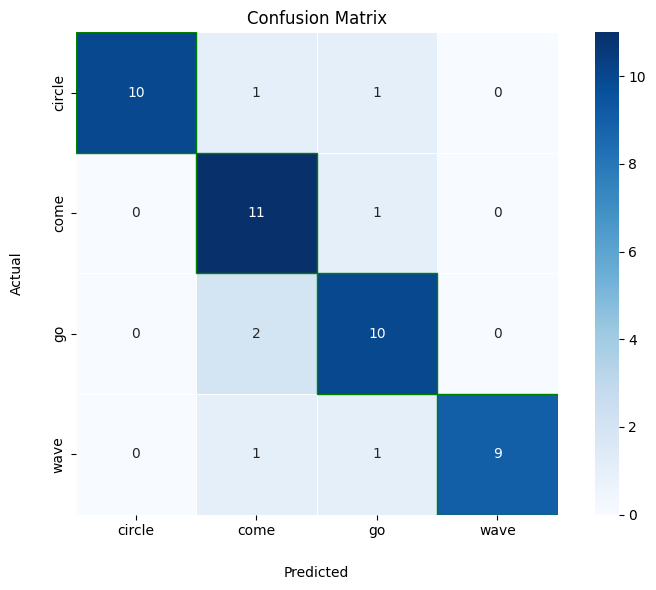

In [99]:
# Support Vector Machines Validation - Ashley Hunt - psyah10

svm_unseen_feature_prediction = svm_model.predict(UNSEEN_FEATURES)

show_classification_report(UNSEEN_LABELS, svm_unseen_feature_prediction)
show_confusion_matrix(UNSEEN_LABELS, svm_unseen_feature_prediction)

### XGBoost

In [100]:
# XGB - Amit Kumar
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_classifier = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [300],
    'max_depth': [20],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1]
}

#param_grid = {
    #'n_estimators': [50, 100, 150],
    #'max_depth': [3, 5, 7],
    #'learning_rate': [0.1, 0.01, 0.001],
    #'subsample': [0.8, 0.9, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0]
#}

knn_grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy')
knn_grid_search.fit(train_features, train_labels)

best_params = knn_grid_search.best_params_
best_estimator = knn_grid_search.best_estimator_

rf_predictions = best_estimator.predict(test_features)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy_score(test_labels, rf_predictions))

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# XGB Validation - Ashley Hunt - psyah10

xgb_unseen_feature_prediction = best_estimator.predict(UNSEEN_FEATURES)

show_classification_report(UNSEEN_LABELS, xgb_unseen_feature_prediction)
show_confusion_matrix(UNSEEN_LABELS, xgb_unseen_feature_prediction)

### Long Short-Term Memory layer (LSTM)

In [ ]:
# LSTM - Amit Kumar
from keras.models import Sequential
from keras.layers import LSTM, Dense

data = df.copy().reset_index()

# Encode the gesture labels
label_encoder = LabelEncoder()
data['gesture_encoded'] = label_encoder.fit_transform(data['gesture'])

# Normalize the features
scaler = StandardScaler()
data[['accel_x', 'accel_y', 'accel_z', 'accel_abs']] = scaler.fit_transform(data[['accel_x', 'accel_y', 'accel_z', 'accel_abs']])

# Define the time steps
time_steps = 10

# Prepare the data for LSTM
def prepare_data_for_lstm(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps]['gesture_encoded'])
    return np.array(X), np.array(y)

X, y = prepare_data_for_lstm(data[['accel_x', 'accel_y', 'accel_z', 'accel_abs', 'gesture_encoded']], time_steps)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(len(label_encoder.classes_), activation='softmax')) # Change activation to softmax for multi-class classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Change loss function for multi-class classification

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
_, test_accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# LSTM - Amit Kumar
test_data = test_df.copy().reset_index()

# Preprocess the new data
test_data['gesture_encoded'] = label_encoder.transform(test_data['gesture'])  # Use the same label encoder as before
test_data[['accel_x', 'accel_y', 'accel_z', 'accel_abs']] = scaler.transform(test_data[['accel_x', 'accel_y', 'accel_z', 'accel_abs']])
 
# Prepare the new data for evaluation
X_new, y_new = prepare_data_for_lstm(test_data[['accel_x', 'accel_y', 'accel_z', 'accel_abs', 'gesture_encoded']], time_steps)
 
y_pred_prob = model.predict(X_new)
y_pred = np.argmax(y_pred_prob, axis=1)
 
# Create a mask for the misclassified samples where the predicted label matches the input label
misclassified_mask = y_pred == y_new
 
# Invert the mask to get the indices of misclassified samples
misclassified_indices = np.logical_not(misclassified_mask)
 
# Decode the predicted labels back into gesture names
predicted_gestures = label_encoder.inverse_transform(y_pred)
 
# Display the gestures with their corresponding predicted labels and accuracy
print("Gesture\t\tPredicted Label")
print("=============================")
for i in range(len(predicted_gestures)):
    # If the sample is misclassified, mark it as such in the output
    if misclassified_indices[i]:
        print(f"{test_data.iloc[i]['gesture']}\t\t{predicted_gestures[i]} (Misclassified)")
    else:
        print(f"{test_data.iloc[i]['gesture']}\t\t{predicted_gestures[i]}")
 
# Calculate and display the overall accuracy
correct_predictions = np.sum(misclassified_mask)
total_predictions = len(y_new)
overall_accuracy = correct_predictions / total_predictions
print("\nOverall Accuracy on Test Data:", overall_accuracy)
 

### KNN

In [ ]:
# KNN - Shreeya Kumbhoje
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Initialize the scaler and the KNN classifier
# scaler = StandardScaler()
knn = KNeighborsClassifier()
 
# Create a pipeline that first scales the data then applies KNN
pipeline = Pipeline([('knn', knn)])

# Parameters of the KNN classifier to tune
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Example range; can be expanded based on computational resources
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
 
# Grid search with cross-validation
knn_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
knn_grid_search.fit(train_features, train_labels)
 
# Best parameters and best score
print("Best parameters:", knn_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(knn_grid_search.best_score_))
 
# Evaluate the best model on the test set
knn_best_model = knn_grid_search.best_estimator_
knn_predictions = knn_best_model.predict(test_features)

show_classification_report(test_labels, knn_predictions)

In [ ]:
knn_unseen_test_pred = knn_best_model.predict(UNSEEN_FEATURES)

show_classification_report(UNSEEN_LABELS, knn_unseen_test_pred)
show_confusion_matrix(UNSEEN_LABELS, knn_unseen_test_pred)

### GRU

In [ ]:
# GRU Model - Shreeya

gesture_df.reset_index(inplace=True)
gesture_df

gesture  gesture_number   accel_x   accel_y   accel_z  accel_abs
0      circle               0  2.890001  1.446576 -0.066413   3.113652
1      circle               0  3.032919  1.212276 -0.128496   3.280432
2      circle               0  3.156924  0.950240 -0.198661   3.449883
3      circle               0  3.259815  0.661212 -0.276283   3.622149
4      circle               0  3.339466  0.346321 -0.360562   3.797378
...       ...             ...       ...       ...       ...        ...
20712    wave             207  1.875776  0.644158  2.060847   2.965680
20713    wave             207  1.545503  0.695033  1.874049   2.669319
20714    wave             207  1.239482  0.729168  1.690910   2.387821
20715    wave             207  0.958820  0.747777  1.512834   2.122016
20716    wave             207  0.704250  0.752147  1.341106   1.872604

[20717 rows x 6 columns]

In [ ]:
#Shreeya Kumbhoje 
import numpy as np
import tensorflow as tf
import random
import os

# Set seed for reproducibility
np.random.seed(38)
random.seed(38)
tf.random.set_seed(38)

# Environment-specific setting to ensure reproducibility
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
#Shreeya Kumbhoje 

import numpy as np
import tensorflow as tf
import random
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Set seed for reproducibility
np.random.seed(38)
random.seed(38)
tf.random.set_seed(38)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

gesture_df.reset_index()


N = gesture_df['gesture'].nunique()


gesture_df['label'] = gesture_df['gesture'].astype('category').cat.codes


grouped = gesture_df.groupby(['gesture', 'gesture_number'])
sequences = [group[1][['accel_x', 'accel_y', 'accel_z', 'accel_abs']].values for group in grouped]
labels = [group[1]['label'].iloc[0] for group in grouped]


sequences_train, sequences_test, labels_train, labels_test = train_test_split(
    sequences, labels, test_size=0.2, random_state=42)

# Pad the sequences so they are all the same length
X_train = pad_sequences(sequences_train, padding='post', dtype='float32')
X_test = pad_sequences(sequences_test, padding='post', dtype='float32', maxlen=X_train.shape[1])

# Convert labels to categorical
y_train = to_categorical(labels_train, num_classes=N)
y_test = to_categorical(labels_test, num_classes=N)

# Define and compile the GRU model
timesteps = X_train.shape[2]  
model = Sequential([
    GRU(64, input_shape=(timesteps, 4), return_sequences=True),
    GRU(32),
    Dense(N, activation='softmax')  
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training set
model.fit(X_train, y_train, epochs=25, batch_size=10)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2069 - loss: 1.3831
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3242 - loss: 1.3569
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2582 - loss: 1.3061
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3742 - loss: 1.2599
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3997 - loss: 1.2413
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3539 - loss: 1.2152
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3962 - loss: 1.1565
Epoch 8/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4930 - loss: 0.9747
Epoch 9/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6601 - loss: 0.7361
Epoch 10/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8774 - loss: 0.5152
Epoch 11/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9349 - loss: 0.3213
Epoch 12/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9641 - l

In [ ]:

test_gesture_df.reset_index(inplace=True)
test_gesture_df

index   accel_x   accel_y   accel_z  accel_abs
0         0  2.954593  0.261950 -0.442816   3.011749
1         1  3.100238 -0.004314 -0.493370   3.190850
2         2  3.214170 -0.287736 -0.548037   3.372962
3         3  3.294322 -0.586823 -0.605682   3.558122
4         4  3.338870 -0.899776 -0.665044   3.746352
...     ...       ...       ...       ...        ...
4434   4434 -4.106620  0.280927  0.370306   3.209075
4435   4435 -3.685088  0.404647  0.263145   2.995568
4436   4436 -3.273097  0.508155  0.163573   2.793482
4437   4437 -2.874130  0.592365  0.072226   2.602391
4438   4438 -2.491262  0.658294 -0.010409   2.421890

[4439 rows x 5 columns]